# YOLOv8 - Treinamento de modelo customizado

Lembrando que o dataset que criamos em aula já se encontra devidamente anotado e convertido para o formato usado pelo YOLO. Isso foi explicado detalhadamente na aula sobre criação do dataset, onde além de fazer a preparação é feito o download de imagens do Open Images Dataset direto pelo Colab.

Caso deseje treinar outros objetos:
* Pode procurar pelo [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html) ou [Kaggle](https://www.kaggle.com) por exemplo, se há um dataset para a classe que deseja detectar.
* Ou pode criar você mesmo o dataset.
Além do LabelImg (que mostramos no curso como é possível fazer a anotação) segue outras ferramentas para fazer a anotação direto pelo navegador e assim não precisar baixar nenhum programa:
  * [MakeSense.ai](https://www.makesense.ai), [CVAT](https://www.cvat.ai), ou ainda a plataforma do [Roboflow](https://app.roboflow.com/login) (inclusive eles oferecem uma integração mais direta com YOLOv8).

Obs: se o seu dataset estiver em outro formato de anotação que não seja do YOLO nem o padrão usado pelo OID, então você pode adaptar o nosso script de conversão de anotações, ou ainda dar uma olhada nas ferramentas que o Roboflow oferece para converter o formato das anotações: https://roboflow.com/formats/yolov8-pytorch-txt

In [ ]:
!nvidia-smi

Tue Nov 21 17:38:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparação do dataset

A estrutura necessária é a seguinte

* /dataset
  * /train
  * /val

In [ ]:
!mkdir dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Copiando o conjunto de imagens de treinamento

In [ ]:
!cp /content/gdrive/MyDrive/Cursos\ -\ recursos/YOLO/recursos/obj.zip ./

In [ ]:
!unzip obj.zip -d dataset/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: dataset/obj/38e38385409deeea.txt  
  inflating: dataset/obj/2dd030eca95066e5.txt  
  inflating: dataset/obj/2201712c0cf468fc.jpg  
  inflating: dataset/obj/0b27052d1fd004a8.txt  
  inflating: dataset/obj/56c7b15c0e765d66.jpg  
  inflating: dataset/obj/b3c0fcb04b0ec197.jpg  
  inflating: dataset/obj/9b557ddee0823b73.jpg  
  inflating: dataset/obj/54aa08e2c98a5988.txt  
  inflating: dataset/obj/533563a9ff6cf2e6.txt  
  inflating: dataset/obj/2facd6a563e58eda.txt  
  inflating: dataset/obj/72b8cca6502c37e1.txt  
  inflating: dataset/obj/e25fd2fd0836cac1.jpg  
  inflating: dataset/obj/79e3f100a8d729fe.txt  
  inflating: dataset/obj/87479ca40ed13a34.txt  
  inflating: dataset/obj/a875fc7fab2dce6b.jpg  
  inflating: dataset/obj/94f7aaa4b60215da.jpg  
  inflating: dataset/obj/a8d6466d56fa3b38.txt  
  inflating: dataset/obj/188579ecec6d3faa.txt  
  inflating: dataset/obj/40f49f633b211977.txt  
  inflating: dataset/obj/dbee

In [ ]:
!mv dataset/obj dataset/train

### Copiando o conjunto de imagens de validação

In [ ]:
!cp /content/gdrive/MyDrive/Cursos\ -\ recursos/YOLO/recursos/valid.zip ./

In [ ]:
!unzip valid.zip -d dataset

Archive:  valid.zip
   creating: dataset/valid/
  inflating: dataset/valid/0354aba2fc6c5903.jpg  
  inflating: dataset/valid/c90f57a9d8fceb90.txt  
  inflating: dataset/valid/ac64309938699c5f.txt  
  inflating: dataset/valid/dcdbabe52cb921f4.txt  
  inflating: dataset/valid/d2e270714f830a69.jpg  
  inflating: dataset/valid/ef87214d8f124297.jpg  
  inflating: dataset/valid/25d107f1590c1772.txt  
  inflating: dataset/valid/f7d8449e6d574541.jpg  
  inflating: dataset/valid/bb0a84b613a098f0.jpg  
  inflating: dataset/valid/cff837a6eb1fc4cb.jpg  
  inflating: dataset/valid/7fb78ae4b57cfb09.jpg  
  inflating: dataset/valid/8d279daa12ffc691.jpg  
  inflating: dataset/valid/f7d8449e6d574541.txt  
  inflating: dataset/valid/6810d6355c7fa115.txt  
  inflating: dataset/valid/8cb7d659e2d0a541.txt  
  inflating: dataset/valid/05dd411f3034ab49.jpg  
  inflating: dataset/valid/b3c1dc254d821440.jpg  
  inflating: dataset/valid/a9f2114462511655.jpg  
  inflating: dataset/valid/589c84743f6e5c8e.txt  
  

## Instalação das ferramentas do YOLOv8

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt

## Configurações do arquivo YAML

In [ ]:
!touch configs_modelo.yaml

Agora, precisamos preencher esse arquivo com os parâmetros necessários

* path: [caminho do diretório que contém o dataset]
* train: [caminho do conjunto de treinamento, relativo ao path]
* val: [caminho do conjunto de validação, relativo ao path]
* test: [não é necessário pois faremos depois um teste manual]

**Número de Classes**
* nc: [coloca o numero de classes que deseja treinar]

**Nomes/Labels - substitua pelos nomes das classes**
* names: [nome de cada classe, dentro de '' e separado por vírgula]

Para escrever esses valores no arquivo, podemos usar o comando %%writefile

In [ ]:
%%writefile configs_modelo.yaml
path: '/content/dataset/'
train: 'train/'
val: 'valid/'
test: # opcional

nc: 3
names: ['Apple', 'Coffe Cup', 'Horse']

Overwriting configs_modelo.yaml


## Treinamento do modelo

In [ ]:
diretorio_raiz = '/content/'
arquivo_config = os.path.join(diretorio_raiz, 'configs_modelo.yaml')

In [ ]:
arquivo_config

'/content/configs_modelo.yaml'

In [ ]:
#!yolo task=detect mode=train data={arquivo_config} epochs=10

> **Parâmetros da função de treinamento:**

* task: o que queremos com o treinamento. Como estamos trabalhando com detecção de objetos, deixe o valor = detect. Outras opções aceitas: segment, e classify. É opcional passarmos se queremos detecção, pois por padrão ele já considera como sendo detecção a não ser que especifique outra forma.
* mode: pode ser train, val, ou predict. Como estamos fazendo pela forma usando python e queremos o treinamento vamos usar a função train(), portanto esse parâmetro se torna desnecessário .
* **model**: o modelo pré-treinado que queremos usar como "partida". Pode ser o YOLOv8 Nano (YOLOv8n), YOLOv8 Small (YOLOv8s), etc.
* **imgsz**: O tamanho da imagem, que a rede realiza o processamento (obs: você não precisa redimensionar a imagem para esse tamanho antes, o algoritmo cuida dessa parte antes de passar a imagem de entrada para a rede). A resolução padrão é 640x640 pixels, portanto o valor padrão é 640. Quando maior o tamanho mais precisa é a detecção, principalmente para objetos com detalhes pequenos, porém é mais demorado o treinamento e detecção.  
* **data**: caminho para o arquivo YAML. Esse é o arquivo que criamos acima, que contém o caminho para o conjunto de treinamento e validaçao, além disso deve conter os nomes das classes que queremos treinar.
* **epochs**: Numero de epocas que desejamos treinar.
* **batch**: O tamanho do batch (lote) para o carregador de dados. Você pode aumentá-lo ou diminuí-lo de acordo com a disponibilidade de memória de sua GPU, por exemplo caso venha a encontrar problema de memória. O valor padrão é 16.
* **name**: Nome do diretório de resultados para o runs/detect. (opcional)

Em nossos testes vamos escolher o Nano, ou até mesmo o Small, pois queremos que seja um treinamento relativamente mais rápido

In [ ]:
model = YOLO('yolov8s.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [ ]:
resultados = model.train(data=arquivo_config, epochs=10, imgsz=640, name='yolov8s_modelo')

Ultralytics YOLOv8.0.32 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=None, data=/content/configs_modelo.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=yolov8s_modelo, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=F

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.Conv                  [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.C2f                   [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.C2f                   [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

In [ ]:
dir_resultado = '/content/runs/detect/yolov8s_modelo'

### Avaliação (Verificando o mAP do modelo)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!yolo task=detect mode=val model={dir_resultado}/weights/best.pt name=yolov8s_modelo_eval data=configs_modelo.yaml

### Exibindo os gráficos

In [ ]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#resultados_grafico

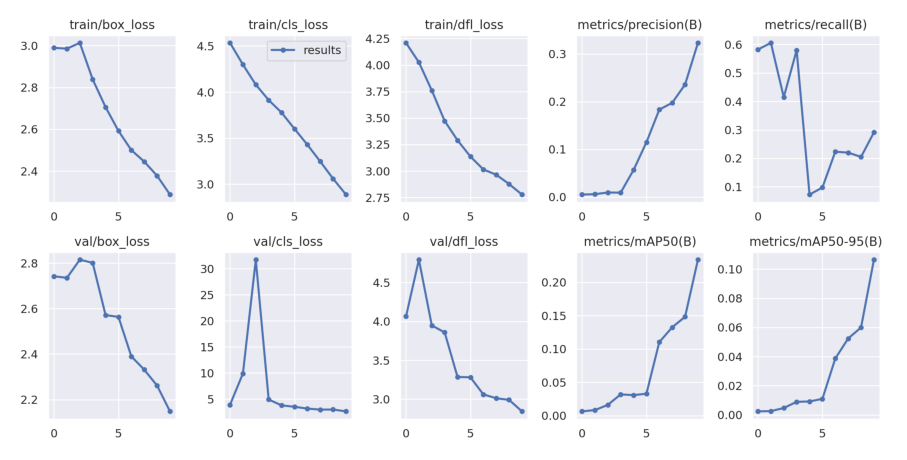

In [ ]:
resultados_grafico = cv2.imread(os.path.join(dir_resultado, 'results.png'))
mostrar(resultados_grafico)

In [ ]:
dir_resultado_val = 'runs/detect/yolov8s_modelo_eval'

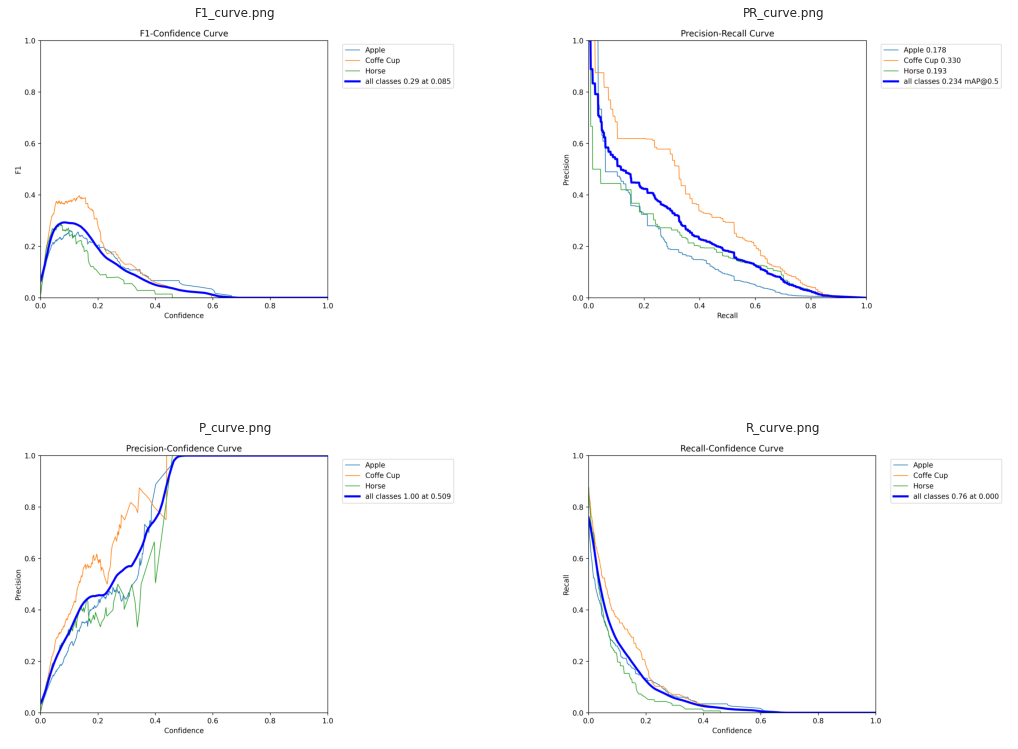

In [ ]:
imgs = ['F1_curve.png', 'PR_curve.png', 'P_curve.png', 'R_curve.png']
plt.figure(figsize=(18,14))
for i, img in enumerate(imgs):
  #print(i, img)
  grafico = cv2.imread(os.path.join(dir_resultado_val, img))
  #print(grafico)
  grafico = cv2.cvtColor(grafico, cv2.COLOR_BGR2RGB)
  plt.subplot(2, 2, i + 1)
  plt.title(imgs[i])
  plt.imshow(grafico)
  plt.axis('off')
plt.show()

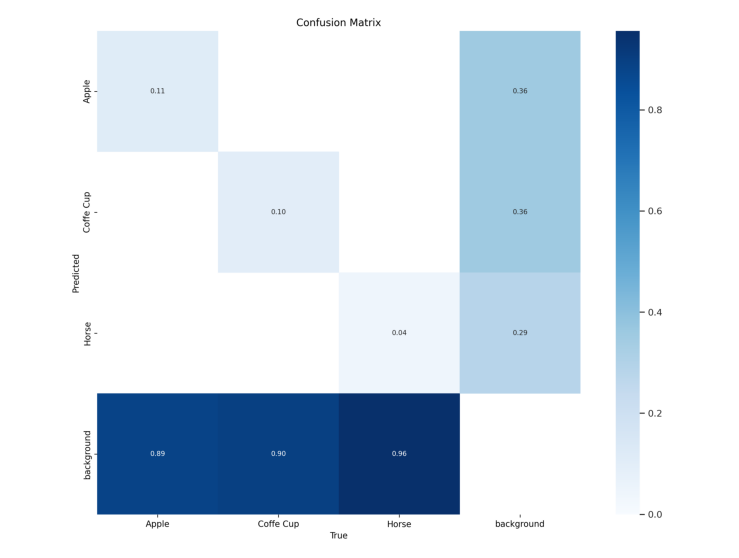

In [ ]:
matriz_confusao = cv2.imread(os.path.join(dir_resultado_val, 'confusion_matrix.png'))
mostrar(matriz_confusao)

## Testando o modelo treinado


In [ ]:
!mkdir imagens_teste

In [ ]:
!yolo task=detect mode=predict model={dir_resultado}/weights/best.pt source='/content/imagens_teste' save=true conf=0.05

Ultralytics YOLOv8.0.32 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8s summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

image 1/3 /content/imagens_teste/apple.jpg: 448x640 3 Apples, 17.1ms
image 2/3 /content/imagens_teste/img-canecas.jpg: 480x640 3 Apples, 5 Coffe Cups, 22.5ms
image 3/3 /content/imagens_teste/person.jpg: 448x640 3 Horses, 14.4ms
Speed: 0.5ms pre-process, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4


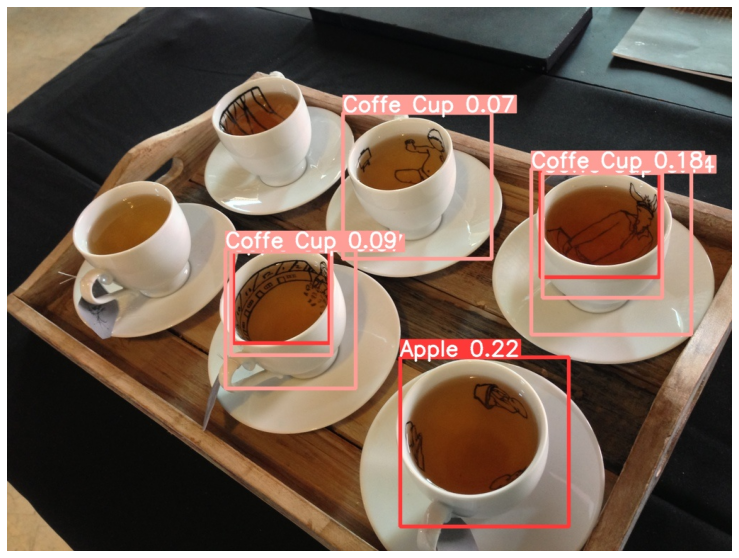

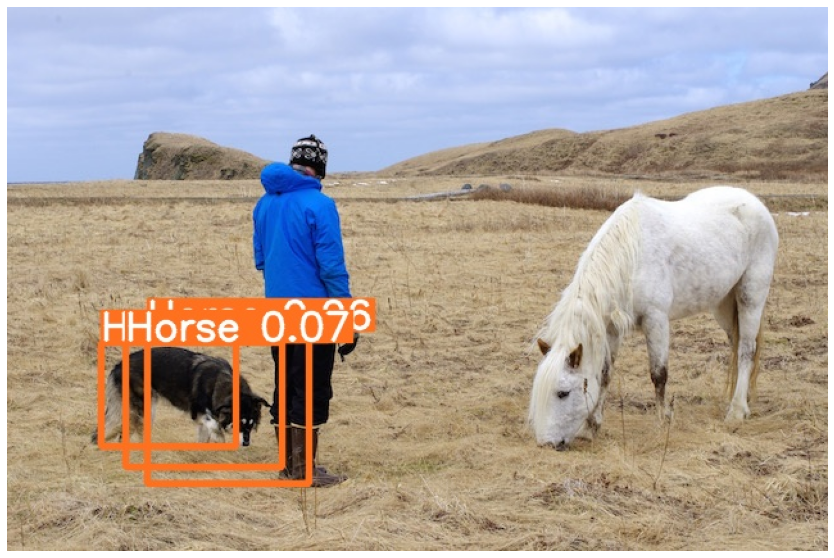

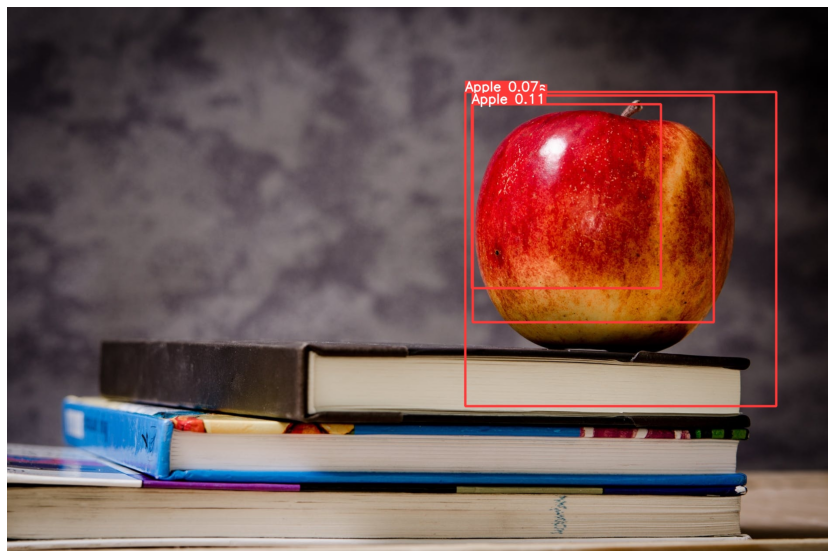

In [ ]:
dir_predicoes = 'runs/detect/predict4/'
caminhos = [os.path.join(dir_predicoes, f) for f in os.listdir(dir_predicoes)]
#print(caminhos)
for caminho_imagem in caminhos:
  imagem = cv2.imread(caminho_imagem)
  mostrar(imagem)

## Continuar treinamento



In [ ]:
!yolo task=detect mode=train model={dir_resultado}/weights/last.pt data={arquivo_config} epochs=10

Ultralytics YOLOv8.0.32 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=/content/runs/detect/yolov8s_modelo/weights/last.pt, data=/content/configs_modelo.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, 

In [ ]:
!yolo task=detect mode=val model={dir_resultado}/weights/best.pt name=yolov8s_modelo_eval data=configs_modelo.yaml

Ultralytics YOLOv8.0.32 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8s summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/dataset/valid.cache... 300 images, 0 backgrounds, 0 corrupt: 100% 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:09<00:00,  2.02it/s]
                   all        300        494      0.319      0.284      0.234      0.106
                 Apple        300        231      0.257       0.26      0.178     0.0934
             Coffe Cup        300        126      0.385      0.372       0.33      0.158
                 Horse        300        137      0.314      0.221      0.193     0.0654
Speed: 1.3ms pre-process, 7.4ms inference, 0.0ms loss, 2.1ms post-process per image


In [ ]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source='imagens_teste' save=true

Ultralytics YOLOv8.0.32 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8s summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

image 1/3 /content/imagens_teste/apple.jpg: 448x640 1 Apple, 22.5ms
image 2/3 /content/imagens_teste/img-canecas.jpg: 480x640 3 Coffe Cups, 22.8ms
image 3/3 /content/imagens_teste/person.jpg: 448x640 2 Horses, 14.7ms
Speed: 0.6ms pre-process, 20.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict5


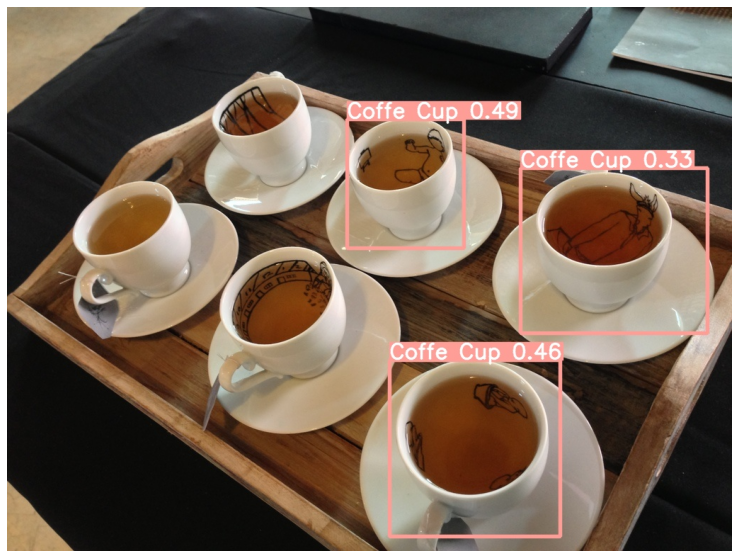

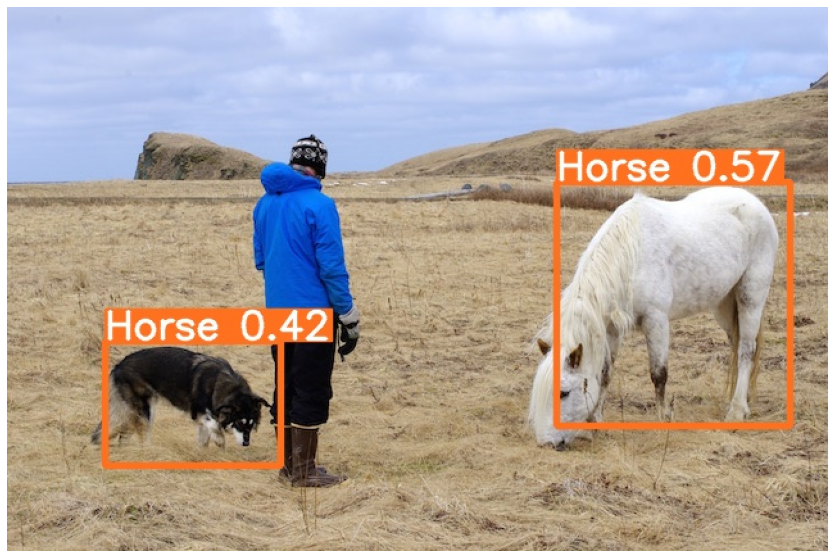

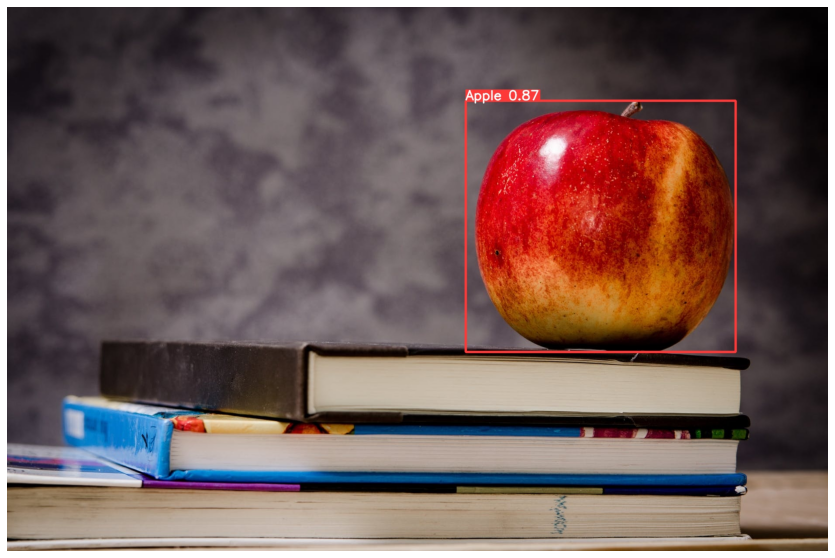

In [ ]:
dir_predicoes = 'runs/detect/predict5/'
caminhos = [os.path.join(dir_predicoes, f) for f in os.listdir(dir_predicoes)]
#print(caminhos)
for caminho_imagem in caminhos:
  imagem = cv2.imread(caminho_imagem)
  mostrar(imagem)

## Enviar para o Google Drive

In [ ]:
!cp -R {dir_resultado} /content/gdrive/MyDrive/Cursos\ -\ recursos/YOLO/yolov8

## Exportar para outros formatos

In [ ]:
os.path.join(dir_resultado, 'weights', 'best.pt')

'/content/runs/detect/yolov8s_modelo/weights/best.pt'

In [ ]:
model_treinado = YOLO(os.path.join(dir_resultado, 'weights', 'best.pt'))
model_treinado.export(format='onnx')

Ultralytics YOLOv8.0.32 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
YOLOv8s summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from /content/runs/detect/yolov8s_modelo/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.4 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.0...
ONNX: export su

Confira a tabela com os formatos aceitos e qual o valor do parâmetro deve ser usado para salvar no formato específico

| Format                                                                     | `format=`          | Model                     |
|----------------------------------------------------------------------------|--------------------|---------------------------|
| [PyTorch](https://pytorch.org/)                                            | -                  | `yolov8n.pt`              |
| [TorchScript](https://pytorch.org/docs/stable/jit.html)                    | `torchscript`      | `yolov8n.torchscript`     |
| [ONNX](https://onnx.ai/)                                                   | `onnx`             | `yolov8n.onnx`            |
| [OpenVINO](https://docs.openvino.ai/latest/index.html)                     | `openvino`         | `yolov8n_openvino_model/` |
| [TensorRT](https://developer.nvidia.com/tensorrt)                          | `engine`           | `yolov8n.engine`          |
| [CoreML](https://github.com/apple/coremltools)                             | `coreml`           | `yolov8n.mlmodel`         |
| [TensorFlow SavedModel](https://www.tensorflow.org/guide/saved_model)      | `saved_model`      | `yolov8n_saved_model/`    |
| [TensorFlow GraphDef](https://www.tensorflow.org/api_docs/python/tf/Graph) | `pb`               | `yolov8n.pb`              |
| [TensorFlow Lite](https://www.tensorflow.org/lite)                         | `tflite`           | `yolov8n.tflite`          |
| [TensorFlow Edge TPU](https://coral.ai/docs/edgetpu/models-intro/)         | `edgetpu`          | `yolov8n_edgetpu.tflite`  |
| [TensorFlow.js](https://www.tensorflow.org/js)                             | `tfjs`             | `yolov8n_web_model/`      |
| [PaddlePaddle](https://github.com/PaddlePaddle)                            | `paddle`           | `yolov8n_paddle_model/`   |



